In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from geopy.geocoders import Photon
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
import torch
import emoji
import re
import cv2
from google.colab.patches import cv2_imshow
from torchvision.io import read_image, ImageReadMode

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
working_dir = '/content/drive/MyDrive/Datasets' #upperdirectorythat coontains data + images
data_dir = os.path.join(working_dir, 'Data', '') # directory that contains data
images_dir = os.path.join(working_dir, 'Images', '') # directory that contains images

In [89]:
print(data_dir)

/content/drive/MyDrive/Datasets/Data/


In [90]:
df_concat = pd.concat([pd.read_csv(f) for f in glob.glob(data_dir + '/*.csv') ], ignore_index=True)
df_concat = df_concat.loc[:, ~df_concat.columns.str.contains('^Unnamed')]

df_concat.dropna(subset=['post_url'], inplace=True) # drop rows that we don't have images for

# drop rows with corapt data
df_concat.drop(df_concat[df_concat['followers'] < 0].index, inplace = True)
df_concat.drop(df_concat[df_concat['followees'] < 0].index, inplace = True)
df_concat.drop(df_concat[df_concat['likes'] < 0].index, inplace = True)
df_concat.drop(df_concat[df_concat['comments'] < 0].index, inplace = True)

# conver business_category to strinng
df_concat['business_category'] = df_concat['business_category'].astype(str)

# conver caption to strinng
df_concat['caption'] = df_concat['caption'].astype(str)

# conver location to strinng
df_concat['location'] = df_concat['location'].astype(str)

df_concat = df_concat.reset_index(drop=True) # reset index
df_concat

,username,followers,followees,is_verified,is_business,business_category,number_of_posts,post_url,caption,hashtags,likes,comments,location,date_utc,img_type
0,fehertwit,104499,28,True,True,Content & Apps,626,https://scontent-hou1-1.cdninstagram.com/v/t51...,At least I don’t have to wear this in Stamford...,[],12225.0,218.0,nan,2021-07-16 15:59:55,GraphImage
1,fehertwit,104499,28,True,True,Content & Apps,626,https://scontent-hou1-1.cdninstagram.com/v/t51...,Silencing all other competitors today at Augus...,"['themasters', 'golf']",6919.0,61.0,nan,2018-04-08 22:47:38,GraphImage
2,fehertwit,104499,28,True,True,Content & Apps,626,https://scontent-hou1-1.cdninstagram.com/v/t51...,Happy 50th birthday to this guy! Nobody rocks ...,[],4125.0,57.0,nan,2020-06-16 13:44:42,GraphSidecar
3,fehertwit,104499,28,True,True,Content & Apps,626,https://scontent-hou1-1.cdninstagram.com/v/t51...,61 years young today... Happy Birthday to the ...,[],3529.0,152.0,nan,2019-08-13 14:46:32,GraphImage
4,fehertwit,104499,28,True,True,Content & Apps,626,https://scontent-hou1-1.cdninstagram.com/v/t51...,"“See David, the key to success in majors is ga...",[],3520.0,22.0,nan,2019-05-18 20:32:12,GraphSidecar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,annehathaway,30980252,101,True,False,nan,738,https://scontent-lga3-1.cdninstagram.com/v/t51...,Mamazon.\nPhotos: @hairbyadir \n@kateleemakeup...,[],3225787.0,20034.0,nan,2019-10-11 19:44:26,GraphSidecar
2667,annehathaway,30980252,101,True,False,nan,738,https://scontent-lga3-1.cdninstagram.com/v/t51...,@voguehongkong and I will just leave these her...,['creativecastingagency'],3096398.0,12795.0,nan,2022-10-29 22:02:03,GraphSidecar
2668,annehathaway,30980252,101,True,False,nan,738,https://scontent-lga3-2.cdninstagram.com/v/t51...,Grazie @donatella_versace and @versace for the...,[],3034865.0,5119.0,nan,2023-03-11 00:26:25,GraphSidecar
2669,annehathaway,30980252,101,True,False,nan,738,https://scontent-lga3-2.cdninstagram.com/v/t51...,✨ Very lucky I was able to celebrate @bulgari'...,"['bulgari', 'bulgarihighjewelry']",3021947.0,7064.0,nan,2023-05-20 17:01:10,GraphSidecar


# Username encoding

In [14]:
def usernanme_encoding(usrn):
  return float(list(np.unique(df_concat['username'])).index(usrn) + 1)

In [15]:
usernanme_encoding('_katiegeorge_')

1.0

# Verification status encoding

In [16]:
print(f"Verification Status: {list(np.unique(df_concat['is_verified']))}")
print(f' False --> {float(False)}, True --> {float(True)}')

Verification Status: [False, True]
 False --> 0.0, True --> 1.0


# Business status encoding

In [17]:
print(f"Business Status: {list(np.unique(df_concat['is_business']))}")
print(f' False --> {float(False)}, True --> {float(True)}')

Business Status: [False, True]
 False --> 0.0, True --> 1.0


# Business category encoding

In [18]:
def business_category_encoding(label):
  list_tmp = list(np.unique(df_concat['business_category']))
  list_tmp.remove('nan')
  list_tmp.insert(0, 'nan')
  list_tmp.remove('None')
  list_tmp.insert(1, 'None')
  return float(list_tmp.index(label))

In [19]:
for elem in list(np.unique(df_concat['business_category'])):
  print(f'{elem} --> {business_category_encoding(elem)}')

Content & Apps --> 2.0
Creators & Celebrities --> 3.0
Entities --> 4.0
Government Agencies --> 5.0
Grocery & Convenience Stores --> 6.0
Home Services --> 7.0
Local Events --> 8.0
None --> 1.0
Personal Goods & General Merchandise Stores --> 9.0
Professional Services --> 10.0
Publishers --> 11.0
nan --> 0.0


# Caption encoding

In [20]:
caption_lenght = []
for caption in list(np.unique(df_concat['caption'])):
  caption_lenght.append(len(caption.strip().split(' ')))

print(caption_lenght)
print(f'MIN: {np.min(caption_lenght)}')
print(f'MEAN: {np.mean(caption_lenght)}')
print(f'MAX: {np.max(caption_lenght)}')
print(f'MEDIAN: {np.median(caption_lenght)}')


[130, 33, 53, 88, 124, 47, 54, 12, 130, 3, 2, 86, 43, 7, 4, 6, 1, 20, 10, 1, 1, 6, 1, 15, 2, 3, 3, 62, 18, 36, 1, 8, 10, 1, 2, 2, 15, 31, 51, 7, 25, 37, 18, 16, 89, 6, 9, 36, 62, 19, 70, 1, 1, 1, 1, 26, 20, 25, 31, 11, 12, 8, 23, 27, 13, 1, 12, 1, 2, 17, 30, 77, 3, 9, 1, 2, 17, 18, 29, 19, 12, 12, 5, 1, 39, 37, 32, 200, 15, 7, 1, 2, 1, 8, 3, 9, 16, 45, 36, 229, 4, 2, 67, 10, 1, 2, 34, 33, 32, 32, 28, 37, 1, 10, 11, 6, 54, 45, 17, 267, 7, 21, 13, 105, 4, 4, 2, 19, 21, 35, 3, 7, 11, 53, 131, 20, 72, 1, 16, 8, 27, 5, 10, 15, 29, 2, 4, 4, 4, 123, 22, 23, 24, 2, 71, 40, 45, 286, 34, 51, 7, 4, 18, 8, 3, 7, 10, 154, 86, 34, 81, 40, 65, 1, 21, 2, 12, 32, 6, 8, 69, 52, 4, 78, 50, 55, 27, 25, 20, 5, 30, 23, 16, 2, 2, 55, 15, 2, 1, 9, 30, 31, 18, 2, 21, 3, 25, 9, 21, 50, 6, 2, 2, 9, 11, 9, 81, 1, 4, 5, 2, 28, 9, 19, 16, 2, 21, 115, 72, 38, 11, 5, 22, 26, 45, 40, 75, 8, 31, 57, 11, 90, 13, 7, 6, 29, 95, 59, 116, 10, 98, 8, 62, 7, 6, 32, 16, 10, 14, 9, 9, 40, 3, 81, 2, 48, 6, 4, 2, 28, 5, 4, 62, 3,

In [21]:
def caption_tokenizer(tokenizer, caption):
  input_ids = tokenizer(caption,max_length=50, padding='max_length', truncation=True).input_ids
  return input_ids

In [22]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.distinct_emoji_list(s))

In [23]:
def caption_encoding(tokenizer, caption):
  return caption_tokenizer(tokenizer, caption), len(extract_emojis(caption))

In [24]:
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
tokenizer.pad_token = tokenizer.eos_token

for caption in list(np.unique(df_concat['caption']))[:5]:
  # input_ids = tokenizer(prompt, return_tensors="pt").input_ids
  print(f'CAPTION: {caption}')
  cap, emoj = caption_encoding(tokenizer, caption)
  print(f'TOKENIZED CAPTION: {cap} & LENGTH: {len(caption_tokenizer(tokenizer,caption))} \n')
  print(f'NUMBER OF EMOJIS: {emoj}')

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

CAPTION: "A world in which elves exist and magic works. "

Everytime we visited that area it felt like being in some kind of fairytale lands with absolutely noone around , I really wanted to represented it like that through the photos . 
We did 5x visits to this area but everytime we just didn't get the right conditions either it started  raining out of nowhere or just massive fog with no visibility at all which seemed to last forever. There was just this one moment which only lasted a few minutes where the magic light came in and we finally got what we wanted .

I guess the story here is if you want something you have to work hard , there are never any shortcuts ever .
#iceland .
@beyondthelands | @simona_br_photography
__________________

www.beyondthelands.com
TOKENIZED CAPTION: [1, 32, 995, 287, 543, 31959, 2152, 290, 5536, 2499, 13, 366, 198, 198, 6109, 2435, 356, 8672, 326, 1989, 340, 2936, 588, 852, 287, 617, 1611, 286, 3148, 20760, 1000, 8604, 351, 5543, 645, 505, 1088, 837, 31

# Hastags encoding

In [25]:
def clean_string(input_string):
    # Replace multiple spaces with a single space
    input_string = re.sub(r'\s+', ' ', input_string)

    # Remove everything except alphanumeric characters, underscores, and spaces
    return re.sub(r'[^\w\s]', '', input_string)

def hastags_count(has_list):
  has_list = clean_string(has_list)
  has_list = has_list.split(' ')
  if has_list == [''] : return 0.0
  else: return float(len(has_list))


In [26]:
for i, has_list in enumerate(list(np.unique(df_concat['hashtags']))[564:567],1):
  print(f'Post #{i} --> Hastag List: {has_list} & Hastag Count: {hastags_count(has_list)}')

Post #1 --> Hastag List: ['synchronic'] & Hastag Count: 1.0
Post #2 --> Hastag List: ['synystergates', 'thedarknight', 'schecterguitars', 'synystergatesschool', 'synner', 'jointhesyndicate'] & Hastag Count: 6.0
Post #3 --> Hastag List: ['tacotuesday'] & Hastag Count: 1.0


# Location encoding

In [27]:
def get_coordinates(address):
    if address == 'nan':
        return 0.0, 0.0

    geolocator = Photon(user_agent="measurements")

    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            return 0.0, 0.0
    except (GeocoderTimedOut, GeocoderUnavailable):
        return 0.0, 0.0

In [28]:
dict_addresses = {}
for addr in tqdm(list(np.unique(df_concat['location']))):
  dict_addresses[addr] = get_coordinates(addr)

100%|██████████| 371/371 [04:47<00:00,  1.29it/s]


In [29]:
dict_addresses

{'16th Hole at the Phoenix Open': (0.0, 0.0),
 'A.F.A. Predio Ezeiza': (-34.6859177, -58.4581601),
 'AREA15': (-13.96101625, 33.76950792327203),
 'Abu Dhabi Golf Club': (24.42021485, 54.52675457764596),
 'Abu Dhabi, United Arab Emirates': (24.4538352, 54.3774014),
 'Agios Prokopios, Naxos': (37.0750385, 25.3513495),
 'Albert Park Circuit-Melbourne': (-37.84029685, 144.9587767846889),
 'Alphaland': (16.4329569, 120.6515014),
 'Altrincham': (53.3839662, -2.3525463),
 'American Airlines Center': (32.8339093, -97.0642477),
 'Amex Stadium': (50.8615535, -0.08487128929500862),
 'Amman, Jordan': (31.9515694, 35.9239625),
 'Amsterdam, Netherlands': (52.3730796, 4.8924534),
 'Anfield Stadium Liverpool Football Club': (0.0, 0.0),
 'Argentina': (-34.9964963, -64.9672817),
 'Around Europe': (49.5565509, 18.8349493),
 'ArtScience Museum': (42.860550950000004, -73.9320504042457),
 'Aschaffenburg, Germany': (49.9740542, 9.1493636),
 'Aspen, Colorado': (39.1911128, -106.82356),
 'Atlanta, Georgia': (3

# Date of Post encoding

In [30]:
def date_encoding(full_date):
  date, hour = full_date.split(' ')
  d = pd.Timestamp(date) # Monday=0 ...

  dict_hour = {0.0: [6, 7, 8, 9, 10, 11, 12],     # Morning   -->  6 am to 12 pm
               1.0: [13, 14, 15, 16, 17],         # Afternoon --> 13 pm to  5 pm
               2.0: [18, 19, 20, 21],             # Evening   -->  6 pm to  9 pm
               3.0: [22, 23, 0, 1, 2, 3, 4, 5] }  # Night     -->  9 pm to  5 am

  whole_hour = int(hour.split(':')[0])
  minutes = int(hour.split(':')[1])
  seconds = int(hour.split(':')[2])

  if (seconds > 30) : minutes += 1
  if (minutes > 30) : whole_hour += 1
  if (whole_hour == 24) : whole_hour = 0

  for key in dict_hour.keys():
    if whole_hour in dict_hour[key] : return float(d.dayofweek), key

In [31]:
date_encoding(list(df_concat[df_concat['username'] == 'hoo.be']['date_utc'])[0])

(0.0, 1.0)

# Image type encoding

In [32]:
def image_type_encoding(img_type):
  return float(list(np.unique(df_concat['img_type'])).index(img_type))

In [33]:
for elem in list(np.unique(df_concat['img_type'])):
  print(f'{elem} --> {image_type_encoding(elem)}')

GraphImage --> 0.0
GraphSidecar --> 1.0


# Image Loader

In [43]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision
from torchvision.models import vgg16, VGG16_Weights

model_VGG = vgg16(pretrained=True)
model_VGG.eval()
weights = VGG16_Weights.DEFAULT


In [91]:
def image_generator(img_path, test_flag=0):
  img_org = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) # original image
  if img_org is None:
    return np.zeros(1000).tolist()

  img_resized = resized = cv2.resize(img_org, (224,224), interpolation = cv2.INTER_AREA) # resize image to 224*224 to be used from VGG-16

  # filename = f"resizedImage-{img_path.strip('.jpg').split('/')[-1]}.jpg"
  filename = "resizedImage.jpg" if test_flag == 0 else "savedImage.jpg"
  cv2.imwrite(filename, img_resized)

  img = read_image(filename,ImageReadMode.RGB)

  preprocess = weights.transforms()
  batch = preprocess(img).unsqueeze(0)
  prediction = model_VGG(batch).squeeze(0).softmax(0)

  if test_flag == 0 : os.remove(filename)

  return prediction.tolist()


Original Size: (1350, 1080, 3)


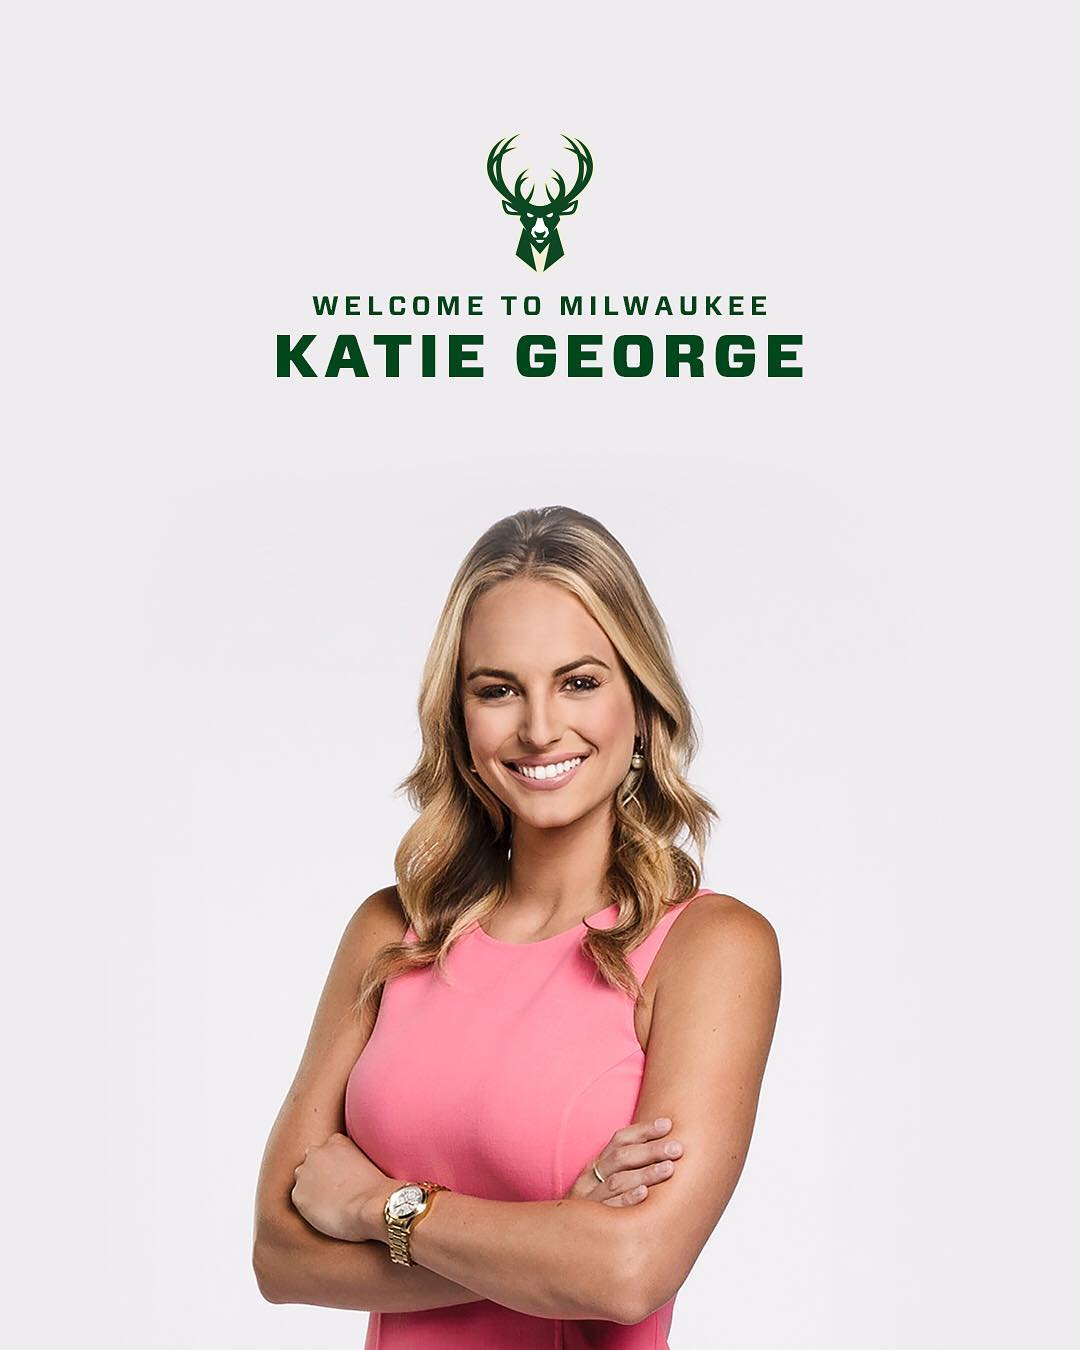

1000


In [92]:
img_path = '/content/drive/MyDrive/Datasets/Images/_katiegeorge__2018-08-17_21__38__43.jpg'

img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
print(f'Original Size: {img.shape}')
cv2_imshow(img)

tensor_image = image_generator(img_path,1)
##print(f'\nTesnor Image Size: {tensor_image.size()}\n')

#img_new = cv2.imread('savedImage.jpg', cv2.IMREAD_UNCHANGED)
#print(f'Reshaped Size: {img_new.shape}')
#cv2_imshow(img_new)
print(len(tensor_image))

# Create dataset

In [94]:
# Define the column headers for the DataFrame
headers = ['Username', 'Followers', 'Followees', 'Verification', 'Business', 'Business Category', 'Posts', 'Caption Token 1', 'Caption Token 2', 'Caption Token 3',
           'Caption Token 4', 'Caption Token 5', 'Caption Token 6', 'Caption Token 7', 'Caption Token 8', 'Caption Token 9', 'Caption Token 10', 'Caption Token 11', 'Caption Token 12',
           'Caption Token 13', 'Caption Token 14', 'Caption Token 15', 'Caption Token 16', 'Caption Token 17', 'Caption Token 18', 'Caption Token 19', 'Caption Token 20', 'Caption Token 21',
           'Caption Token 22', 'Caption Token 23', 'Caption Token 24', 'Caption Token 25', 'Caption Token 26', 'Caption Token 27', 'Caption Token 28', 'Caption Token 29', 'Caption Token 30',
           'Caption Token 31', 'Caption Token 32', 'Caption Token 33', 'Caption Token 34', 'Caption Token 35', 'Caption Token 36', 'Caption Token 37', 'Caption Token 38', 'Caption Token 39',
           'Caption Token 40', 'Caption Token 41', 'Caption Token 42', 'Caption Token 43', 'Caption Token 44', 'Caption Token 45', 'Caption Token 46', 'Caption Token 47', 'Caption Token 48',
           'Caption Token 49', 'Caption Token 50', 'Emojis Count', 'Hashtags', 'Latitude', 'Longitude', 'Date', 'Time', 'Image Type', 'Likes', 'Comments']


# Create an empty DataFrame with these headers
df_dataset = pd.DataFrame(columns=headers)

# Define Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
tokenizer.pad_token = tokenizer.eos_token


for i in tqdm(range(len(df_concat))):
  dir_tmp = {}
  #print(i)
  # Tensor Image
  img_path = os.path.join(images_dir, df_concat.loc[i]['username'] + '_' + str(df_concat.loc[i]['date_utc']).replace(" ", "_").replace(":","__")) + '.jpg'
  vgg_img =  image_generator(img_path)
  for i in range(len(vgg_img)):
    dir_tmp[str(i)] = vgg_img[i]

  # Username
  usrn = df_concat.loc[i]['username']
  dir_tmp["Username"] = usernanme_encoding(usrn)

  # Followers
  followers = df_concat.loc[i]['followers']
  dir_tmp["Followers"] = float(followers)

  # Followees
  followees = df_concat.loc[i]['followees']
  dir_tmp["Followees"] = float(followees)

  # Verification
  is_verified = df_concat.loc[i]['is_verified']
  dir_tmp["Verification"] = float(is_verified)

  # Business
  is_business = df_concat.loc[i]['is_business']
  dir_tmp["Business"] = float(is_business)

  # Business Category
  bus_label = df_concat.loc[i]['business_category']
  dir_tmp["Business Category"] = business_category_encoding(bus_label)

  # Posts
  num_posts = df_concat.loc[i]['number_of_posts']
  dir_tmp["Posts"] = float(num_posts)

  # Caption Token & Emojis Count
  caption = df_concat.loc[i]['caption']
  cap_tokens, emoj_count = caption_encoding(tokenizer, caption)
  for j, tok in enumerate(cap_tokens, 1):
    dir_tmp[f"Caption Token {j}"] = float(tok)
  dir_tmp["Emojis Count"] = float(emoj_count)

  # Hashtags
  has_list = df_concat.loc[i]['hashtags']
  dir_tmp["Hashtags"] = hastags_count(has_list)

  # Latitude & Longitude
  loc = df_concat.loc[i]['location']
  lat, lon = get_coordinates(loc)
  # lat, lon = dict_addresses[loc]
  dir_tmp["Latitude"] = lat
  dir_tmp["Longitude"] = lon

  # Date and Time
  full_date = df_concat.loc[i]['date_utc']
  date, time = date_encoding(full_date)
  dir_tmp["Date"] = date
  dir_tmp["Time"] = time

  # Image Type
  img_type = df_concat.loc[i]['img_type']
  dir_tmp["Image Type"] = image_type_encoding(img_type)

  ####################################################################

  # Likes
  likes = df_concat.loc[i]['likes']
  dir_tmp["Likes"] = float(likes)

  # Comments
  comments = df_concat.loc[i]['comments']
  dir_tmp["Comments"] = float(comments)

  # Add the row to the DataFrame
  df_dataset = df_dataset.append(dir_tmp, ignore_index=True)


100%|██████████| 2671/2671 [40:57<00:00,  1.09it/s]


In [95]:
df_dataset

,Username,Followers,Followees,Verification,Business,Business Category,Posts,Caption Token 1,Caption Token 2,Caption Token 3,...,990,991,992,993,994,995,996,997,998,999
0,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,1.540743e-08,5.848895e-08,5.764909e-08,8.989597e-08,2.967782e-07,1.279557e-07,2.918121e-07,7.234205e-09,1.324046e-06,1.510216e-03
2667,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,2.215644e-08,2.976236e-08,4.801437e-09,4.831751e-08,5.136811e-07,3.722031e-08,1.971586e-08,1.011932e-08,2.002270e-07,2.401269e-07
2668,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,7.198442e-08,6.232727e-08,9.155664e-08,3.690384e-07,4.337970e-06,6.601301e-07,2.282336e-06,3.176082e-08,1.150381e-06,2.318747e-05
2669,94.0,22566.0,71.0,1.0,1.0,1.0,348.0,464.0,717.0,1683.0,...,1.244301e-07,4.659513e-08,6.310743e-07,1.079178e-07,7.582918e-06,3.400634e-06,1.740985e-06,3.382646e-07,2.276448e-03,2.955427e-06


In [96]:
df_dataset.to_csv(f'Dataset_Complete_new.csv')

# Visualisation - Grpahs

In [ ]:
# for file in os.listdir(images_dir):
#     old_file = os.path.join(images_dir, file)
#     new_file = os.path.join(images_dir, file.replace(" ","_"))
#     os.rename(old_file, new_file)

In [ ]:
# hastag_list = ['nan']
# tot_len = 0
# for has_list in list(np.unique(df_concat['hashtags'])):
#   has_list = [j.strip('[], ') for j in has_list.split(',')]
#   tot_len += len(has_list)
#   # for has in has_list:
#   #   print(has)
#   #   if has not in hastag_list: hastag_list.append(has)

# tot_len